In [3]:
# # Debugging ONLY! autoreloads when scripts update
# %load_ext autoreload
# %autoreload 2

import numpy as np
import pandas as pd
import geopandas as gpd

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm
import contextily as ctx

import os

from src import preprocessing, config, plotting, utils

# Obtain raw data

This step calls functions in `src/preprocessing/` to perform the following:
- Fetch the 2020 Decennial Census Demographic Profile through the Census API
- Fetch select variables from the 2023 American Community Survey (5-Year), defined in `src/config.py`, through the Census API
- Save the resulting raw data to paths defined in `src/config.py` with the variable names `config.*_RAW`

In [2]:
# Get 2020 Decennial Census data
decennial2020_dp_raw = preprocessing.fetch_2020_demographic_profile()
np.array(decennial2020_dp_raw).shape

GET request status: 200


(2328, 646)

In [2]:
# Get 2023 ACS 5yr data
acs5yr2023_raw = preprocessing.fetch_2023_acs_5yr_select()
np.array(acs5yr2023_raw).shape

GET request status: 200


(2328, 26)

# Perform initial cleaning

This first cleaning step calls functions in `src/preprocessing/` to perform the following:
- Remove unnecessary columns
- Rename the remaining columns to be human-readable
- Subtract water area from Census tract geometries for more intuitive plotting
- Convert numeric columns to numeric data types (from strings)
- Fill in undefined values as np.nan
- Save the resulting dataframes in `data/interim/` to paths defined in `src/config` with the variable names `config.*_CLEAN`

In [3]:
# Clean NYC census tract shapefiles
gdf = preprocessing.clean_tracts(config.TRACTS_RAW, config.TRACTS_CLEAN, config.AREAWATER)

print(gdf.shape)
gdf.sample(n=5)

(2324, 6)


,BOROUGH,TRACT,AREA,LAT,LONG,geometry
GEOID,,,,,,
36081011600,Queens,116,136938,40.688776,-73.838805,"POLYGON ((-73.84105 40.69028, -73.83926 40.690..."
36081099703,Queens,997.03,576606,40.782975,-73.774705,"POLYGON ((-73.78223 40.78913, -73.78218 40.789..."
36081035800,Queens,358,524484,40.675791,-73.750980,"POLYGON ((-73.75549 40.67663, -73.75524 40.677..."
36047015300,Brooklyn,153,150477,40.668100,-73.980576,"POLYGON ((-73.98343 40.66864, -73.98293 40.669..."
36047120000,Brooklyn,1200,150529,40.674877,-73.867272,"POLYGON ((-73.87044 40.67722, -73.86978 40.677..."


In [4]:
decennial2020_dp_clean = preprocessing.clean_2020_demographic_profile()
print(decennial2020_dp_clean.shape)
decennial2020_dp_clean.sample(n=5)

(2327, 153)


,pop,pop_under5,pop_5to9,pop_10to14,pop_15to19,pop_20to24,pop_25to29,pop_30to34,pop_35to39,pop_40to44,pop_45to49,pop_50to54,pop_55to59,pop_60to64,pop_65to69,pop_70to74,pop_75to79,pop_80to84,pop_85plus,pop_16plus,pop_18plus,pop_21plus,pop_62plus,pop_65plus,pop_male,pop_male_under5,pop_male_5to9,pop_male_10to14,pop_male_15to19,pop_male_20to24,pop_male_25to29,pop_male_30to34,pop_male_35to39,pop_male_40to44,pop_male_45to49,pop_male_50to54,pop_male_55to59,pop_male_60to64,pop_male_65to69,pop_male_70to74,pop_male_75to79,pop_male_80to84,pop_male_85plus,pop_male_16plus,pop_male_18plus,pop_male_21plus,pop_male_62plus,pop_male_65plus,pop_female,pop_female_under5,pop_female_5to9,pop_female_10to14,pop_female_15to19,pop_female_20to24,pop_female_25to29,pop_female_30to34,pop_female_35to39,pop_female_40to44,pop_female_45to49,pop_female_50to54,pop_female_55to59,pop_female_60to64,pop_female_65to69,pop_female_70to74,pop_female_75to79,pop_female_80to84,pop_female_85plus,pop_female_16plus,pop_female_18plus,pop_female_21plus,pop_female_62plus,pop_female_65plus,medianage,medianage_male,medianage_female,pop_onerace,pop_white,pop_black,pop_nativeam,pop_asian,pop_hipacific,pop_other,pop_multi,racetally,racetally_white,racetally_black,racetally_nativeam,racetally_asian,racetally_hipacific,racetally_other,pop_hispanic,pop_nonhispanic,pop_hispanic_white,pop_hispanic_black,pop_hispanic_nativeam,pop_hispanic_asian,pop_hispanic_hipacific,pop_hispanic_other,pop_hispanic_multi,pop_nonhisp_white,pop_nonhisp_black,pop_nonhisp_nativeam,pop_nonhisp_asian,pop_nonhisp_hipacific,pop_nonhisp_other,pop_nonhisp_multi,pop_household,pop_household_householder,pop_household_spouse_oppsex,pop_household_spouse_samesex,pop_household_unmpartner_oppsex,pop_household_unmpartner_samesex,pop_household_child,pop_household_child_under18,pop_household_grandchild,pop_household_grandchild_under18,pop_household_otherrelatives,pop_household_nonrelatives,pop_gpquarters,pop_gpquarters_institutionalized,pop_gpquarters_institutionalized_male,pop_gpquarters_institutionalized_female,pop_gpquarters_noninst,pop_gpquarters_noninst_male,pop_gpquarters_noninst_female,households,households_married,households_married_withchild,households_cohabit,households_cohabit_withchild,households_singlemale,households_singlemale_alone,households_singlemale_alone_65plus,households_singlemale_withchild,households_singlefemale,households_singlefemale_alone,households_singlefemale_alone_65plus,households_singlefemale_withchild,households_withunder18,households_with65plus,housing,housing_occupied,housing_vacant,housing_vacant_forrent,housing_vacant_rentedunocc,housing_vacant_forsale,housing_vacant_soldunocc,housing_vacant_seasonal,housing_vacant_other,vacancyrate_homeowner,vacancyrate_rental,housing_owneroccupied,housing_renteroccupied
GEOID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
36047029100,3042,128,128,105,119,316,507,373,226,171,170,153,148,158,108,74,73,36,49,2659,2609,2510,443,340,1437,61,72,60,63,149,238,182,102,76,82,83,71,76,45,25,28,10,14,1234,1200,1150,168,122,1605,67,56,45,56,167,269,191,124,95,88,70,77,82,63,49,45,26,35,1425,1409,1360,275,218,33.0,32.1,33.4,2759,683,1710,22,101,3,240,283,3349,835,1877,57,175,12,393,472,2570,42,83,15,3,3,204,122,641,1627,7,98,0,36,161,2967,1303,208,17,106,21,620,327,60,23,177,455,75,0,0,0,75,33,42,1301,223,73,126,22,350,220,40,15,602,263,118,88,252,313,1485,1301,184,53,10,19,4,0,98,5.9,5.0,299,1002
36047036700,1796,122,122,115,111,161,228,176,140,113,107,94,99,73,40,43,25,16,11,1412,1382,1302,183,135,792,55,64,41,44,72,113,72,64,44,44,45,50,28,13,18,13,8,4,619,606,583,75,56,1004,67,58,74,67,89,115,104,76,69,63,49,49,45,27,25,12,8,7,793,776,719,108,79,30.7,30.3,31.1,1605,200,958,28,49,0,370,191,2011,306,1055,55,74,6,515,655,1141,93,78,22,0,0,343,119,107,880,6,49,0,27,72,1504,533,132,2,44,5,455,278,35,27,169,129,292,0,0,0,292,45,247,516,123,50,46,19,143,89,12,11,20

In [3]:
# Clean 2023 ACS 5-year data
acs5yr2023_clean = preprocessing.clean_2023_acs_5yr_select()

print(acs5yr2023_clean.shape)
acs5yr2023_clean.sample(n=10)

(2327, 11)


,pct_sameresidence1yr,pct_englishonlyhome,pct_commute_transit,pct_commute_walk,medianhouseholdincome,pct_incomebelowpoverty,pct_housing_1unitdetached,pct_housing_1unitattached,pct_housing_20plusunits,medianhomevalue,medianrent
GEOID,,,,,,,,,,,
36047026400,90.1,12.2,63.9,9.6,70151.0,22.2,2.2,9.4,20.1,1078600.0,1775.0
36005042100,80.8,16.6,58.6,19.7,55830.0,28.8,0.0,0.0,95.1,252900.0,1512.0
36047090000,96.1,80.5,75.5,1.9,22396.0,48.2,6.7,3.1,37.3,533600.0,1321.0
36005033000,88.7,43.0,61.0,6.4,48750.0,22.4,8.1,5.4,54.5,601100.0,1282.0
36005037400,97.8,45.0,58.7,3.2,35884.0,32.7,10.4,1.8,65.5,473000.0,1171.0
36047013100,85.4,80.3,54.3,6.1,109875.0,8.9,0.6,3.2,3.7,963300.0,2841.0
36047033702,82.8,73.3,24.1,24.4,84941.0,13.7,1.9,9.3,3.0,1218800.0,1555.0
36061007002,73.3,85.2,24.1,24.6,158158.0,6.4,1.2,0.6,78.6,1556400.0,3501.0
36047013500,85.4,82.5,37.6,8.7,214028.0,1.8,2.1,7.4,19.0,1707200.0,3244.0


# Stage 2 cleaning

## Remove low population, low household tracts

To reduce noise in fractional values calculated later, remove any tracts with a small number of people or households.

In [39]:
# Load in dataframes
decennial2020_dp_clean = pd.read_parquet(config.DECENNIAL2020_DP_CLEAN)
acs5yr2023_clean = pd.read_parquet(config.ACS5YR2023_CLEAN)
tracts_clean = gpd.read_parquet(config.TRACTS_CLEAN)

In [40]:
# Get rows with population >= 200 and households >= 100
is_highpop = (decennial2020_dp_clean["pop"] >= 200) & (decennial2020_dp_clean["households"] >= 100)
rows_highpop = decennial2020_dp_clean[is_highpop].index
print(is_highpop.describe()) # Only 13/2327 tracts (~0.5%) are excluded

count     2327
unique       2
top       True
freq      2212
dtype: object


In [41]:
decennial2020_dp_highpop = decennial2020_dp_clean.loc[rows_highpop]
acs5yr2023_highpop = acs5yr2023_clean.loc[rows_highpop]
tracts_highpop = tracts_clean.loc[rows_highpop]

# Check that all dataframes have the same number of rows
print(f"decennial2020_dp_highpop has shape {decennial2020_dp_highpop.shape}")
print(f"acs5yr2023_highpop has shape {acs5yr2023_highpop.shape}")
print(f"tracts_highpop has shape {tracts_highpop.shape}")

decennial2020_dp_highpop has shape (2212, 153)
acs5yr2023_highpop has shape (2212, 11)
tracts_highpop has shape (2212, 6)


## Remove NaN from ACS tracts using geographic interpolation

The Decennial Demographic Profile data has no undefined variables, but the ACS data does. Fill in data using a geographic interpolation technique (function defined in `src/utils/`) that computes a value for a tract representing an average of the tract's neighbors with well-defined values, weighted by border length.

In [42]:
acs5yr2023_highpop.isna().sum()

pct_sameresidence1yr           0
pct_englishonlyhome            0
pct_commute_transit            0
pct_commute_walk               0
medianhouseholdincome         24
pct_incomebelowpoverty         0
pct_housing_1unitdetached      0
pct_housing_1unitattached      0
pct_housing_20plusunits        0
medianhomevalue              276
medianrent                    25
dtype: int64

In [43]:
for col in ["medianhouseholdincome", "medianhomevalue", "medianrent"]:
    acs5yr2023_highpop[col] = utils.interpolate_from_neighbors(
        tracts_highpop, acs5yr2023_highpop[col],
        verbose=False
    )

c:\Users\dylan\Anaconda3\envs\datasci\Lib\site-packages\libpysal\weights\contiguity.py:61: UserWarning: The weights matrix is not fully connected: 
 There are 8 disconnected components.
 There are 3 islands with ids: 36005051601, 36081091603, 36081107201.
  W.__init__(self, neighbors, ids=ids, **kw)
c:\Users\dylan\Anaconda3\envs\datasci\Lib\site-packages\libpysal\weights\contiguity.py:61: UserWarning: The weights matrix is not fully connected: 
 There are 8 disconnected components.
 There are 3 islands with ids: 36005051601, 36081091603, 36081107201.
  W.__init__(self, neighbors, ids=ids, **kw)
c:\Users\dylan\Anaconda3\envs\datasci\Lib\site-packages\libpysal\weights\contiguity.py:61: UserWarning: The weights matrix is not fully connected: 
 There are 8 disconnected components.
 There are 3 islands with ids: 36005051601, 36081091603, 36081107201.
  W.__init__(self, neighbors, ids=ids, **kw)


## Remove docks causing fictitious contiguity

Some census tracts in Manhattan seem to include docks in Brooklyn, which makes them appear adjacent in a way we don't want. Let's manually remove them.

(<Figure size 600x450 with 1 Axes>, <Axes: title={'center': 'Census tracts'}>)

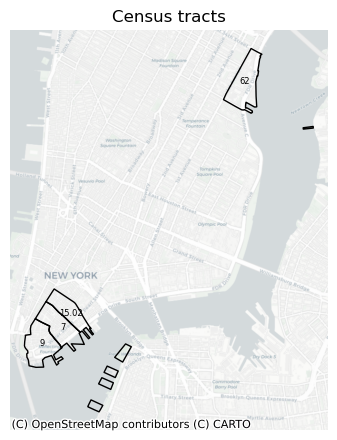

In [44]:
# -- Identify and plot these tracts --
dock_tract_ids = ["36061" + s for s in ["000900","000700","001502","006200"]]
dock_tracts = tracts_highpop.loc[dock_tract_ids]

plotting.plot_tracts(dock_tracts)

In [51]:
# -- Explode out MultiPolygons and keep only the larger chunks --
dock_tracts = dock_tracts.to_crs(config.WEB_MERCATOR_EPSG)
dock_tracts.explode().geometry.area

GEOID
36061000900    444916.286783
36061000900     36734.417581
36061000900     38927.890105
36061000700    406141.185495
36061000700     34948.599467
36061001502    308994.261999
36061001502     54714.897470
36061006200    505729.294382
36061006200      6047.148624
dtype: float64

(<Figure size 600x450 with 1 Axes>, <Axes: title={'center': 'Census tracts'}>)

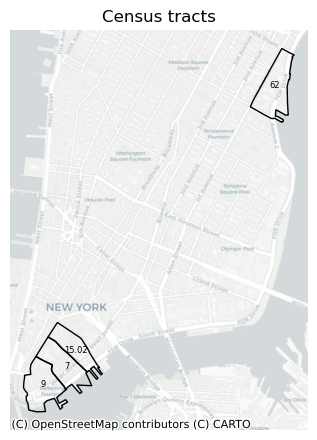

In [53]:
# -- Replace original tracts with clipped ones --
dock_tracts_clipped = dock_tracts.explode().iloc[[0,3,5,7]]
dock_tracts_clipped = dock_tracts_clipped.to_crs(config.WGS84_EPSG)
for id in dock_tract_ids:
    tracts_highpop.loc[id] = dock_tracts_clipped.loc[id]
plotting.plot_tracts(tracts_highpop.loc[dock_tract_ids])

## Save new tracts

In [55]:
# Save 2nd stage cleaning
decennial2020_dp_highpop.to_parquet(config.DECENNIAL2020_DP_HIGHPOP)
acs5yr2023_highpop.to_parquet(config.ACS5YR2023_HIGHPOP)
tracts_highpop.to_parquet(config.TRACTS_HIGHPOP)